### Imports

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Functions

In [47]:
def create_series(N,mode=0):
    series = np.sin(0.1*np.arange(N)) 
    if mode==1:
        series += np.random.randn(N)*0.1
    return series

def plot_series(series):
    plt.plot(series)
    plt.show()
    
    
def create_dataset_rnn(T,N,mode=0):
    series = create_series(N,mode)
    X = []
    Y = []
    for t in range(len(series)-T):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T]
        Y.append(y)
    X = np.array(X).reshape(-1,T,1)
    Y = np.array(Y).reshape(-1,1)
    N = len(X)
    print(N)
    print("X.shape",X.shape,"Y.shape",Y.shape)
    return X,Y

class SimpleRNN(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_rnnlayers, n_outputs,device):
        super(SimpleRNN,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.device = device
        
        self.rnn = nn.RNN(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            nonlinearity = 'relu',
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
        
        out,_ = self.rnn(X, h0)
        
        out = self.fc(out[:, -1, :])
        return out

        

def create_model_and_train(X,Y,T,N,n_epochs=100):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1,device=device)
    print(device)
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.1)
    
    # random split is not reasonable in time series
    
    X_train = torch.from_numpy(X[:-N//2].astype(np.float32)).to(device)
    y_train = torch.from_numpy(Y[:-N//2].astype(np.float32)).to(device)
    X_test = torch.from_numpy(X[-N//2:].astype(np.float32)).to(device)
    y_test = torch.from_numpy(Y[-N//2:].astype(np.float32)).to(device)
    
    train_losses = np.zeros(n_epochs)
    test_losses  = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses[it] = loss.item()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        
        if (it+1)%5==0:

            print(f"Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
        
    return model,train_losses, test_losses, device,X_test,y_test

def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show
    
    
def wrong_forcasting(Y,N,T,X_test):
    validation_target = Y[-N//2:]
    validation_predictions = []
    
    i=0
    while len(validation_predictions)<len(validation_target):
        input_ = X_test[i].view(1,T,1)
        p = model(input_)[0,0].item()
        i+=1
        validation_predictions.append(p)
        
    return validation_predictions,validation_target

def correct_forcasting(Y,N,T,X_test):
    validation_target = Y[-N//2:]
    validation_predictions = []
    
    last_x = X_test[0].view(T)
    
    while len(validation_predictions)<len(validation_target):
        input_ = last_x.view(1,T,1)
        p = model(input_)
        
        validation_predictions.append(p[0,0].item())
        
        last_x = torch.cat((last_x[1:],p[0]))
        
    return validation_predictions,validation_target

### Create data

In [31]:
# series = create_series(N=1000,mode=0)

In [32]:
# plot_series(series)

In [68]:
T=10
N=1000
X , Y = create_dataset_rnn(T=T,N=N,mode=1)
N = len(X)

# try with both mode 0 and 1 (without noise and with noise)

990
X.shape (990, 10, 1) Y.shape (990, 1)


In [69]:
# plot_series(X)

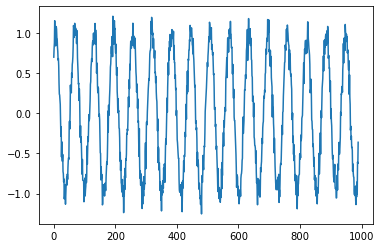

In [70]:
plot_series(Y)

### Create and train model

In [71]:
model,train_losses, test_losses, device, X_test, y_test = create_model_and_train(X,Y,T=T,N=N,n_epochs=200)

cpu
Epoch 5/200, Train Loss: 0.5384, Test Loss: 0.5128
Epoch 10/200, Train Loss: 0.5298, Test Loss: 0.5075
Epoch 15/200, Train Loss: 0.4364, Test Loss: 0.3770
Epoch 20/200, Train Loss: 0.1433, Test Loss: 0.0935
Epoch 25/200, Train Loss: 0.0837, Test Loss: 0.0983
Epoch 30/200, Train Loss: 0.0866, Test Loss: 0.0701
Epoch 35/200, Train Loss: 0.0310, Test Loss: 0.0337
Epoch 40/200, Train Loss: 0.0553, Test Loss: 0.0492
Epoch 45/200, Train Loss: 0.0319, Test Loss: 0.0300
Epoch 50/200, Train Loss: 0.0383, Test Loss: 0.0348
Epoch 55/200, Train Loss: 0.0281, Test Loss: 0.0262
Epoch 60/200, Train Loss: 0.0296, Test Loss: 0.0274
Epoch 65/200, Train Loss: 0.0256, Test Loss: 0.0245
Epoch 70/200, Train Loss: 0.0261, Test Loss: 0.0242
Epoch 75/200, Train Loss: 0.0252, Test Loss: 0.0243
Epoch 80/200, Train Loss: 0.0249, Test Loss: 0.0237
Epoch 85/200, Train Loss: 0.0251, Test Loss: 0.0239
Epoch 90/200, Train Loss: 0.0249, Test Loss: 0.0239
Epoch 95/200, Train Loss: 0.0249, Test Loss: 0.0238
Epoch 100

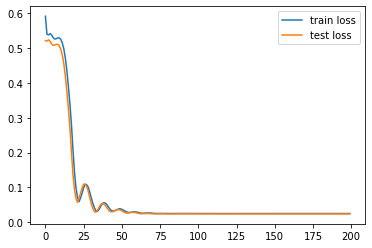

In [72]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")

### Wrong forecasintg

In [73]:
validation_predictions,validation_target = wrong_forcasting(Y,N,T,X_test)

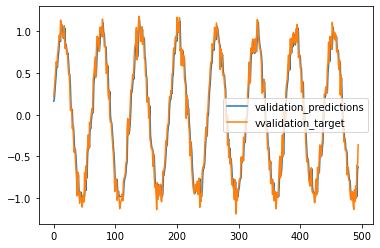

In [74]:
plot_metric(validation_predictions, "validation_predictions")
plot_metric(validation_target, "vvalidation_target")

### Correct forecasting

In [75]:
validation_predictions,validation_target = correct_forcasting(Y,N,T,X_test)

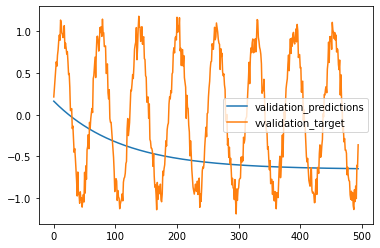

In [76]:
plot_metric(validation_predictions, "validation_predictions")
plot_metric(validation_target, "vvalidation_target")

In [1]:
# RNN might have good results sometimes but it is not confident, so it needs more tuning.